In [3]:
# data processing packages
import numpy as np
import pandas as pd
from pandas import DataFrame

# model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
from keras.models import load_model
import glob

# evaluation packages
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve

# plot packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# obtain valid data
signal_test = pd.read_hdf('./data/signal_test.hdf','signal')

feature_name = signal_test.columns.tolist()
feature_name.remove('eid')
feature_name.remove('truth_matching')
feature_name.remove('upsmcmass')
feature_name.remove('A1mcmass')
feature_name.remove('A2mcmass')
feature_name.remove('A3mcmass')

X_test = signal_test[feature_name]
y_test = signal_test['truth_matching']
print X_test.shape, y_test.shape

weight_test = np.zeros(y_test.shape)
weight_test = weight_test + 1
weight_test[y_test==1] = y_test.shape[0] / sum(y_test)

(880105, 17) (880105,)


/Users/yunxuanli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Plotting ROC curve...
./models/dt.pkl
./models/gbdt100.pkl
./models/lg.pkl
./models/rf10.pkl


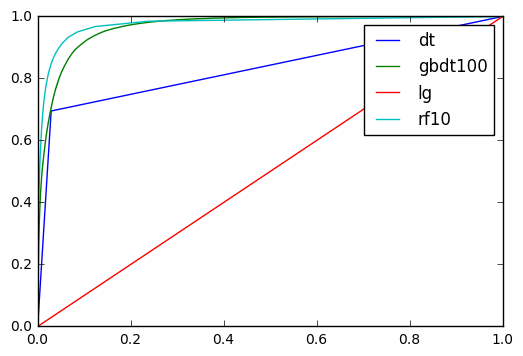

In [2]:
# ROC curve:
print 'Plotting ROC curve...'
model_list_sklearn = glob.glob('./models/*.pkl')
model_list_keras = glob.glob('./models/*.h5')
model_list = model_list_sklearn + model_list_keras

for model in model_list:
    print model
    if(model in model_list_sklearn):
        rf = joblib.load(model)
        y_pred_prob = rf.predict_proba(X_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-4])
    elif(model in model_list_keras):
        rf = load_model(model)
        y_pred_prob = rf.predict(X_test.values)
        fpr,tpr,thresholds = roc_curve(y_test.values, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-3])
    else:
        print 'Error'

plt.legend()

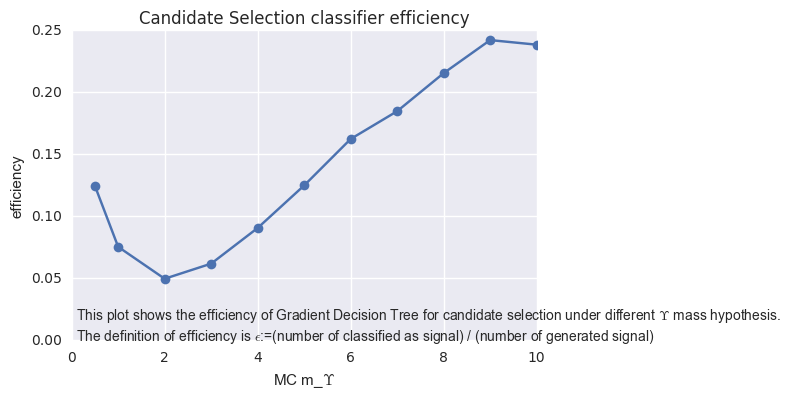

In [4]:
# efficiency for gbdt100 under different upsmcmass
rf = joblib.load('./models/gbdt100.pkl')

upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
N_count_list = []
delta = 0.1
for upsmcmass_ in upsmcmass_list:
    signal_upsmcmass = signal_test[(signal_test.upsmcmass<upsmcmass_+delta) & (signal_test.upsmcmass>upsmcmass_-delta)]
    y_pred = rf.predict(signal_upsmcmass[feature_name])
    N_count = sum(y_pred)*1.0 / signal_upsmcmass.shape[0]
    N_count_list.append(N_count)
    
plt.plot(upsmcmass_list, N_count_list,'-o')
plt.xlabel('MC m_$\Upsilon$')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different $\Upsilon$ mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(.1, 0, txt)

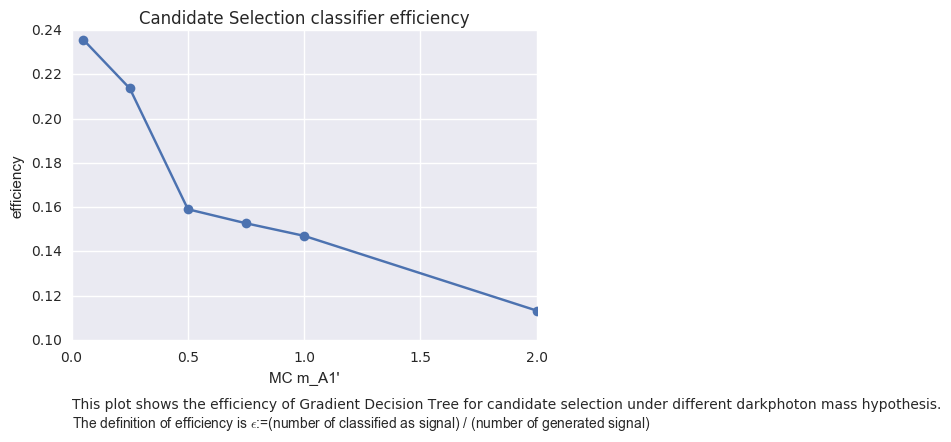

In [42]:
# efficiency for gbdt100 under different A' mcmass
rf = joblib.load('./models/gbdt100.pkl')

Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
N_count_list = []
delta = 0.1
for Amcmass_ in Amcmass_list:
    signal_Amcmass = signal_test[(signal_test.A1mcmass<Amcmass_+delta) & (signal_test.A1mcmass>Amcmass_-delta)]
    y_pred = rf.predict(signal_Amcmass[feature_name])
    N_count = sum(y_pred)*1.0 / signal_Amcmass.shape[0]
    N_count_list.append(N_count)
    
plt.plot(Amcmass_list, N_count_list,'-o')
plt.xlabel('MC m_A1\'')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different darkphoton mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(0, 0.06, txt)